<a href="https://colab.research.google.com/github/kimsejin111/speedlimit_classification/blob/main/transfer_training_tt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
# drive connect
_URL='https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cat_and_dogs.zip',origin=_URL,extract=True)
PATH=os.path.join(os.path.dirname(path_to_zip),'cats_and_dogs_filtered')

train_dir=os.path.join(PATH,'train')
validation_dir=os.path.join(PATH,'validation')

BATCH_SIZE=32
IMG_SIZE=(160,160)

#dataset_dir+batch_size_img_size
train_dataset=image_dataset_from_directory(train_dir,
                                           shuffle=True,
                                           batch_size=BATCH_SIZE,
                                           image_size=IMG_SIZE)

validation_dataset=image_dataset_from_directory(validation_dir,
                                           shuffle=True,
                                           batch_size=BATCH_SIZE,
                                           image_size=IMG_SIZE)



#test_img_plot
class_names=train_dataset.class_names
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
val_batches=tf.data.experimental.cardinality(validation_dataset)
test_dataset=validation_dataset.take(val_batches//5)
validation_dataset=validation_dataset.skip(val_batches//5)


AUTOTUNE=tf.data.AUTOTUNE
train_dataset=train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset=validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset=test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#data augmentation
data_augmentation=tf.keras.Sequential(
    [
     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ]
)

In [ ]:
#pixel_ rescaling for MobilNetV2 [-1,1] -->  [0,255]

preprocess_input =tf.keras.applications.mobilenet_v2.preprocess_input
rescale=tf.keras.layers.experimental.preprocessing.Rescaling(1/127.5, offset=-1)


In [ ]:
#Create the base model
IMG_SHAPE=IMG_SIZE+(3,)
base_model=tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

In [ ]:
image_batch, label_batch=next(iter(train_dataset))
feature_batch=base_model(image_batch)

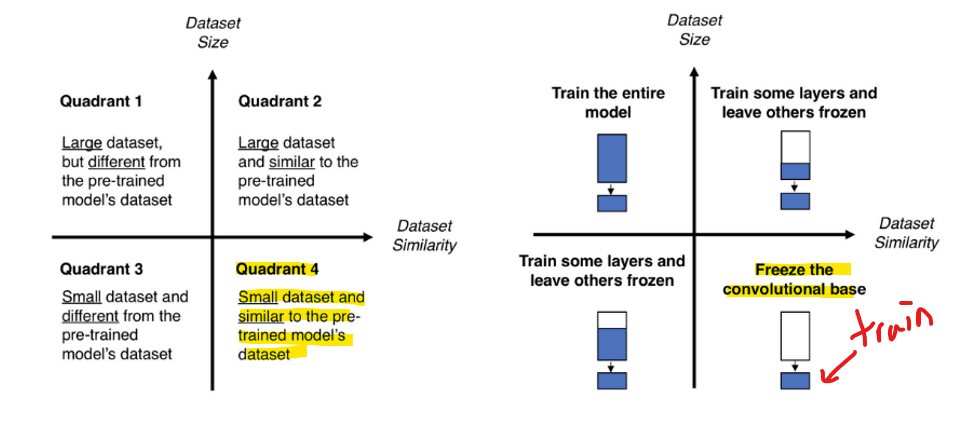

In [ ]:
#feature extraction

#base model freeze
base_model.trainable=False 

base_model.summary()




In [ ]:
#classification_layer_add
global_average_layer=tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average=global_average_layer(feature_batch)

#feature transfor to sigle prediction for each image
prediction_layer=tf.keras.layers.Dense(1)
prediction_batch=prediction_layer(feature_batch_average)

In [ ]:
#Model definition
inputs=tf.keras.Input(shape=(160,160,3))
x=data_augmentation(inputs)
x=preprocess_input(x)
x=base_model(x,training=False) #Traing=False --> for Batch_Normalization
x=global_average_layer(x)
x=tf.keras.layers.Dropout(0.2)(x)
outputs=prediction_layer(x)
model=tf.keras.Model(inputs,outputs)

#Model compile
base_learning_rate=0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr= base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
)
model.summary()

In [ ]:
len(model.trainable_variables) # bias & weight

In [ ]:
#model training

initial_epochs=10
loss0, accuracy0 =model.evaluate(validation_dataset)

history=model.fit(train_dataset,
                  epochs=initial_epochs,
                  validation_data=validation_dataset)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Sepecific layer fine tuning
base_model.trainable=True
fine_tune_at=100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable=False


#Model compile
base_learning_rate=0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr= base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
)


model.summary()
len(model.trainable_variables)

In [ ]:
#model_training
fine_tune_epochs=10
total_epochs=initial_epochs+fine_tune_epochs
history_fine=model.fit(train_dataset,
                       epochs=total_epochs,
                       initial_epoch=history.epoch[-1],
                       validation_data=validation_dataset)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")